# Glacier mass change data from satellite and in-situ observations: uncertainty analysis for glaciological and hydrological monitoring

Production date: 17-07-2024

Update: 26-01-2025

Dataset version: WGMS-FOG-2023-09

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Quantifying the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring

## ❓ Quality assessment question
* **"Is the glacier mass change dataset sufficiently adequate in terms of its uncertainty to effectively monitor and evaluate global (cumulative) glacier mass changes over time, including their associated impacts on global sea level rise?"**

Glaciers significantly impact global sea-level rise, freshwater resources, natural hazards, hydro-power generation, recreation and tourism. Assessing glacier mass changes due to climate warming is therefore crucial for addressing these issues. The "[Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database](https://cds.climate.copernicus.eu/datasets/derived-gridded-glacier-mass-change?tab=overview)" (version WGMS-FOG-2023-09) on the Climate Data Store (CDS), offers a global coverage of glacier mass changes by integrating in-situ, aerial, and satellite data [[1](https://wgms.ch/), [2](https://essd.copernicus.org/preprints/essd-2024-323/)]. When measured over a long period and at extended geographical scales, trends in glacier mass balance can be considered a clear indicator of global climate change [[3](https://www.nature.com/articles/s41586-019-1071-0)]. Despite some known issues, this dataset provides valuable insights into glacier mass changes across spatial and temporal scales. In that regard, this notebook investigates how well the dataset can be used to quantify the link between glacier melt and glacier-related sea level contributions. More specifically, the notebook evaluates whether the dataset is of sufficient maturity and quality for that purpose in terms of its uncertainty.

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
- The gridded glaciers mass change dataset that is on the CDS is currently the most complete dataset of glacier mass change data in terms of its spatial coverage. It is generally considered the main reference dataset to determine the glaciers mass change across the globe. A quantitative pixel-by-pixel error estimate is available for the dataset in the form of precision errors (reported as 1.96 times the standard deviation). Concerning these errors, the dataset shows a general decrease in glacier mass change uncertainty over time, with recent years (after 2000 CE) meeting proposed international standards of uncertainty thresholds [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]. However, the uncertainty is highly spatially variable, with areas like the peripheral glaciers in Greenland and Antarctica exhibiting higher glacier mass change errors. Hence, not all pixels meet the minimum uncertainty threshold, of which users should take not. For error propagation, it is furthermore not stated whether errors are spatially or temporally correlated.
- The dataset is nevertheless highly suitable to monitor and derive global (cumulative) mass changes over time and to, for example, assess the corresponding impact on global sea level changes in the context of Earth System modeling and climate change monitoring. The dataset has sufficient quality in terms of its uncertainty (which is especially true during the more recent years and outside certain regions such as the peripheral areas of Antarctica and Greenland) and its consistency with respect to spatial (i.e. global) and temporal (i.e. since 1975-76) coverage. However, in order to calculate effective global sea level changes (i.e. to exclude glacier ice that does not contribute to global sea level changes), additional external information is required from the user. Users should also note some potential key limitiations: there is a lack of detailed sampling information, and its use for individual glacier-scale (smaller than the pixel-scale) applications is limited. Due to variations in data collection methods and sources, data consistency along the data may furthermore be affected.
```

## 📋 Methodology

### Dataset description

The mass balance of a glacier is the difference between mass gained (from snow accumulation) and mass lost (by meltwater runoff or solid ice discharge into lakes/the ocean), which is the same as the net mass change of a glacier. In general, the basis for the derived gridded mass changes are individual measurements (mainly glaciological in-situ local annual surface mass balance measurements) and geodetic air or spaceborne elevation change data (a surface elevation/ice thickness change or an ice volume change over time). These data are converted into an averaged specific mass balance value (i.e. mostly reported with units of meter water equivalent and often shortened to m w.e.) for an individual glacier. Afterwards, the data are submitted to the World Glacier Monitoring Service (WGMS). Further processing of the data results in a glacier mass change product reported over a 0.5° global grid dating back until the 1975-76 hydrological year. Each grid cell therefore contains a time series of total glacier mass change (in Gt yr⁻¹) or mass balance data (in m w.e. yr⁻¹) of all glaciers within the specific grid cell. In this notebook, we use version WGMS-FOG-2023-09. For a more detailed description of the data acquisition and processing methods, we refer to the [documentation on the CDS](https://cds.climate.copernicus.eu/datasets/derived-gridded-glacier-mass-change?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355349383) (Copernicus Knowledge Base).

It is important to note that not all glaciers in the dataset exhibit a time series of directly measured annual in-situ mass balance observations, but that most glaciers in the dataset are either unobserved or only have (limited and mostly multi-annual) geodetic mass change data available. Glacier mass change data with these geodetic samples are also more prone to uncertainties in general, for example due to uncertainties related to volume to mass conversions. Nevertheless, the glaciers with an annual glaciological sample (ca. 500 glaciers) form the basis for the determination of annual mass changes from the remaining glaciers through a complex algorithm of spatial/temporal interpolation and (area-weighted) avereging of these mass change data [[2](https://essd.copernicus.org/preprints/essd-2024-323/)].

### Structure and (sub)sections

- Data preparation and processing
- Glacier mass changes and their uncertainty estimates in space and time
- Quantifying global (cumulative) glacier mass changes since 1975-76
- Quantification of glacier-related contributions to global sea level change

## 📈 Analysis and results

### Data preparation and processing

First we load the packages:

In [1]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import rasterio.features
from rasterio.transform import from_origin
from scipy.stats import linregress
import os
from c3s_eqc_automatic_quality_control import download
plt.style.use("seaborn-v0_8-notebook")

############### PLEASE DELETE THE LINE BELOW BEFORE PUBLICATION ###############
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
############### PLEASE DELETE THE LINE ABOVE BEFORE PUBLICATION ###############

Then we define the parameters, i.e. for which years we want the glacier mass change data to be downloaded:

In [4]:
period_start = "1975_1976"
period_stop = "2021_2022"
# This line validates that both period_start and period_stop meet specific criteria: 
# They contain an underscore ("_") and their length is exactly 9 characters.
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))

Then we define requests for download from the CDS and download and transform the glacier mass change data.

In [5]:
# Set request
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))
collection_id = "derived-gridded-glacier-mass-change"
request = {
    "variable": "glacier_mass_change",
    "product_version": "wgms_fog_2023_09",
    "format": "zip",
    "hydrological_year": [
        f"{y0}_{str(y1)[-2:]}"
        for y0, y1 in zip(range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1))
    ],
}

# Download glacier mass change data
print("Downloading glacier mass change data...")

ds = download.download_and_transform(
    collection_id,
    request,
)

print("Downloading done.")

100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


Lastly, we can read and inspect the glacier mass change data. Let us print out the data to inspect its structure:

In [6]:
ds

<xarray.Dataset> Size: 487MB
Dimensions:                  (time: 47, latitude: 360, longitude: 720)
Coordinates:
  * time                     (time) datetime64[ns] 376B 1976-01-01 ... 2022-0...
  * latitude                 (latitude) float64 3kB 89.75 89.25 ... -89.75
  * longitude                (longitude) float64 6kB -179.8 -179.2 ... 179.8
Data variables:
    glacier_mass_change_gt   (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_mass_change_mwe  (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_area_km2         (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_gt           (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_mwe          (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    title:                 Global gridded annual glacier mass changes
    data_version:          version-wgms-fog-2023-09
    project:               Copernicus Climate Change Service (C3S) Essential ...
    institution:           World Glacier Monitoring Service - Geography Depar...
    created_by:            Dr. Ines Dussaillant - ines.dussaillant@geo.uzh.ch
    references:            Fluctuation of Glaciers (FoG) database version wgm...
    citation:              Dussaillant, I., Bannwart, J., Paul, F., Zemp, M. ...
    conventions:           CF Version CF-1.8
    dataset_description:   Horizontal resolution: 0.5° (latitude - longitude)...
    dataset_limitations:   Grid-point artefact in polar regions: see Algorith...
    dataset_improvements:  Improvements of product version WGMS-FOG-2023-09 w...
    comments:              Conversions between annual grid point mass change ...

It is a gridded dataset at a 0.5 by 0.5 degree spatial resolution containing annual values of the total glacier mass change (in Gt yr$^{-1}$) of a grid cell (`glacier_mass_change_gt`) and its uncertainty (`uncertainty_gt`) since the 1975-76 hydrological year. Mass changes (mass balances in this case) and their uncertainty can also be extracted in units of m w.e. yr$^{-1}$ (`glacier_mass_change_mwe` and `uncertainty_mwe`). The parameterized absolute glacier surface area is furthermore also available in this dataset by the variable `glacier_area_km2`. For conversion purposes, glacier mass changes (in Gt yr$^{-1}$) can be converted into glacier mass balances (in m w.e. yr$^{-1}$) by dividing the mass changes (in Gt yr$^{-1}$ multiplied by $1*10^{12}$ to get values in kg yr$^{-1}$) by the product of the density of water (1000 kg m$^{-3}$) and the glacier area (in km$^{2}$ multiplied by $1*10^6$ to get values in m$^2$).

Let us perform some data handling before getting started with the analysis:

In [7]:
# Customize attributes in glacier mass change file
ds["time"] = ds["time"].dt.year
ds["time"].attrs |= {"long_name": "Time", "units": "yr"}
for da in ds.data_vars.values():
    da.attrs["units"] += " $yr^{-1}$"
    da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

# Compute cumulative glacier mass change/balance and area
ds_glacier_gt = ds["glacier_mass_change_gt"].sum(("latitude", "longitude"), keep_attrs=True)
ds_glacier_mwe = (((ds["glacier_mass_change_mwe"]) * (ds["glacier_area_km2"]*1e6)).sum(dim=("latitude", "longitude"), keep_attrs=True)) / ((ds["glacier_area_km2"]*1e6).sum(dim=("latitude", "longitude"), keep_attrs=True))
ds_glacier_area_km2 = ds["glacier_area_km2"].sum(("latitude", "longitude"), keep_attrs=True)

# Compute errors
weights = ds["glacier_area_km2"] * 1e6  # Convert km² to m² for weights
values = ds['uncertainty_mwe'] / 1.96  # Divide uncertainty by 1.96 to get standard deviation
normalized_weights = weights / weights.sum(dim=['latitude', 'longitude'], keep_attrs=True)
weighted_errors = (normalized_weights * values) ** 2
ds_error_mwe = (weighted_errors.sum(dim=['latitude', 'longitude'], keep_attrs=True) ** 0.5)
ds_error_gt = ((ds['uncertainty_gt']/1.96) ** 2).sum(dim=['latitude', 'longitude'],keep_attrs=True) ** 0.5

# Sum over time
annual_gt = ds_glacier_gt
annual_err_gt = ds_error_gt
cumulative_gt = ds_glacier_gt.cumsum("time")
cumulative_err_gt = ((ds_error_gt**2).cumsum("time")) ** 0.5
annual_mwe = ds_glacier_mwe
annual_err_mwe = ds_error_mwe
cumulative_mwe = ds_glacier_mwe.cumsum("time")
cumulative_err_mwe = ((ds_error_mwe**2).cumsum("time")) ** 0.5
annual_glacier_area = ds_glacier_area_km2

# Add to the dataframe
ds["Cumulative_gt"] = cumulative_gt
ds["Annual_gt"] = annual_gt
ds["Cumulative_error_gt"] = cumulative_err_gt
ds["Annual_error_gt"] = annual_err_gt
ds["Cumulative_mwe"] = cumulative_mwe
ds["Annual_mwe"] = annual_mwe
ds["Cumulative_error_mwe"] = cumulative_err_mwe
ds["Annual_error_mwe"] = annual_err_mwe
ds["Annual_area_km2"] = annual_glacier_area

### Glacier mass changes and their uncertainty estimates in space and time

#### Glacier mass change uncertainties: accuracy and precision

The total error of an annual glacier mass change estimate is theoretically given by the sum of the precision (random) and the accuracy (systematic) error:

$
\varepsilon = \sigma + \delta
$
where $\sigma$ is the random error (i.e. standard deviation) and $\delta$ the systematic error. 

In the glacier mass change dataset, precision errors are reported as 1.96 times the standard deviation and the accuracy error is not considered [[2](https://essd.copernicus.org/preprints/essd-2024-323/)]. Therefore, in our case, $\delta$ is 0. In the following section below, we will thus consider the uncertainty of the dataset as being $1.96 \sigma$.

Let us now explore a bit more the uncertainty of the data. The pixel-by-pixel quantitative uncertainties that accompany the data arise from different sources, of which the most important ones are the input data measurement uncertainties, the density conversion for geodetic mass balances, and errors related to absolute glacier areas and their changes over time. All these processes and parameters thus play a key role in determining the final estimate of the glacier mass changes. The errors from these various sources are combined in the final product and the authors report these uncertainty values as being precision errors in the form of $1.96 \sigma$ (i.e. equivalent to a 95% confidence interval for a normal distribution) with units in Gt yr⁻¹ or m w.e. yr⁻¹. 

In the following, we will, however, change the units of the error to kg m⁻² yr⁻¹ because GCOS advises glacier mass change uncertainty values to be provided in these units [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]: 

$
\varepsilon_{\Delta{M}}
$
[kg m⁻² yr⁻¹]
$
= 1 \cdot 10^{6} * \left(\dfrac{1.96 \sigma}{A}\right)
$

where $1.96 \sigma$ is the pixel mass change uncertainty [Gt yr⁻¹] from `uncertainty_gt` and $A$ the pixel glacier surface area [km²] from `glacier_area_km2`.

We can plot a histogram of the error term over all pixels and all years to inspect its distribution:

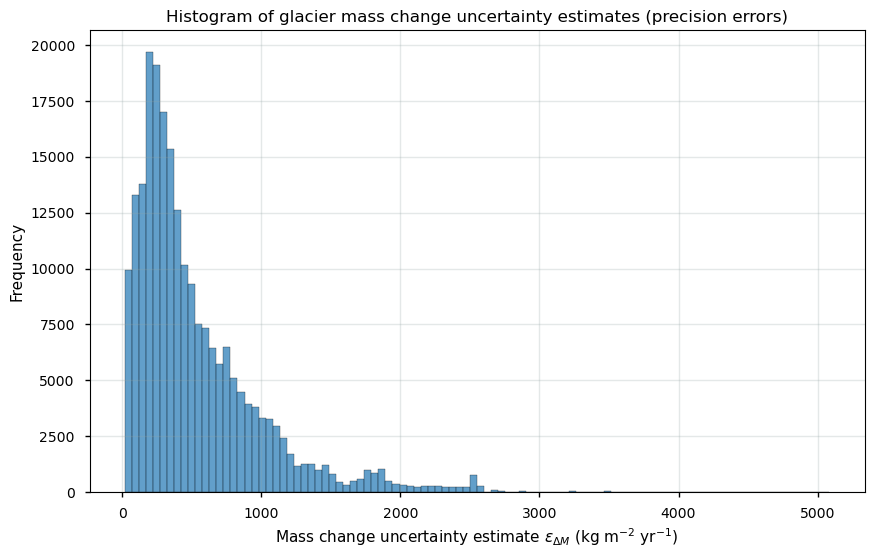

In [8]:
# Plot the histogram
plt.figure(figsize=(10, 6))
error_kg_m2_yr = (1e6*ds['uncertainty_gt'].values.flatten()) / (ds['glacier_area_km2'].values.flatten())
plt.hist(error_kg_m2_yr, bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of glacier mass change uncertainty estimates (precision errors)')
plt.xlabel('Mass change uncertainty estimate $\epsilon_{\Delta{M}}$ (kg m$^{-2}$ yr$^{-1}$)')
plt.ylabel('Frequency')
plt.grid(color='#95a5a6',linestyle='-',alpha=0.25)
plt.show()

*Figure 1. Histogram of pixel-by-pixel glacier mass change errors in the glacier mass change dataset.*

Let us plot some statistics:

In [9]:
print(f"The overall arithmetic mean precision error over all pixels and all years is {np.nanmean(error_kg_m2_yr):.2f} kg m\u207B² yr\u207B\u00B9 with a maximum of {np.nanmax(error_kg_m2_yr):.2f} kg m\u207B² yr\u207B\u00B9.")

The overall arithmetic mean precision error over all pixels and all years is 530.69 kg m⁻² yr⁻¹ with a maximum of 5083.96 kg m⁻² yr⁻¹.


#### Glacier mass change errors over time

The overall arithmetic mean error over both space and time exhibits a moderate magnitude, and the majority of errors seem to be situated close to 200-500 kg m⁻² yr⁻¹. The threshold (i.e. the minimum requirement to be met to ensure that data are useful) for glacier mass change uncertainty (expressed in terms of 2$\sigma$) proposed by the GCOS is 500 kg m⁻² yr⁻¹, while the "breakthrough" value (i.e. the level at which specified uses within climate monitoring become possible) would be 200 kg m⁻² yr⁻¹ per grid point [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)].

As an extra step, we can calculate the overall arithmetic mean glacier mass change precision error for each hydrological year to get a general idea of the overall magnitude of the errors. This is simply calculated as the spatial arithmetic mean of all pixels for each year $t$:

$\overline{\varepsilon_{\Delta{M}}}_{x,y}  
$
[kg m⁻² yr⁻¹]
$ = \dfrac{1}{n} \sum\limits^{{{x,y}}} (\varepsilon_{\Delta{M_{x,y}}})$ with $x,y$ the spatial domain size and $n$ is the total amount of latitude/longitude pixels (NaN pixels with no glaciers are excluded).

This results in the following:

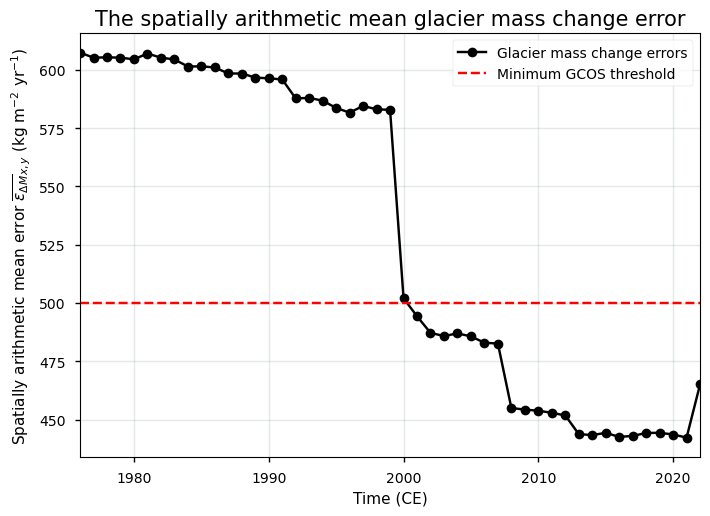

In [10]:
# Calculate area-weighted mean error for each year
mean_error_per_year = []

for t in ds['time']:
    errors = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2']).sel(time=t).values
    
    # Flatten the arrays to perform the weighted mean calculation
    errors_flat = errors.flatten()
    
    # Calculate the area-weighted mean error
    mean_error = np.nanmean(errors_flat)
    mean_error_per_year.append(mean_error)

# Convert to a numpy array or xarray DataArray if needed
mean_error_per_year = np.array(mean_error_per_year)

fig, ax = plt.subplots()
ax.plot(ds['time'].values, mean_error_per_year,'k',label='Glacier mass change errors',marker='o')
ax.axhline(y=500, color='r', linestyle='--',label='Minimum GCOS threshold')
ax.set_xlabel("Time (CE)")
ax.set_ylabel("Spatially arithmetic mean error $\overline{\epsilon_{\Delta{M}}}_{x,y}$ (kg m$^{-2}$ yr$^{-1}$)")
ax.set_title("The spatially arithmetic mean glacier mass change error", fontsize=15)
ax.grid(color='#95a5a6', linestyle='-', alpha=0.25)
ax.set_xlim(np.min(ds['time'].values), np.max(ds['time'].values))
plt.legend()
plt.show()

*Figure 2. Time series of annual spatially averaged (arithmetic) glacier mass change errors in the glacier mass change dataset. The red dotted line represents the minimum uncertainty threshold proposed by GCOS [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)].*

#### Glacier mass change errors in space

Next, let us check the spatial distribution of the mean overall error over time per grid point, which is simply calculated as the temporal arithmetic mean over all years for each pixel $x,y$:

$\overline{\varepsilon_{\Delta{M_{t}}}} 
$
[kg m⁻² yr⁻¹]
$ = \dfrac{1}{n} \sum\limits_{i={1976}}^{{{1976+n-1}}} (\varepsilon_{\Delta{M_i}})$ with $n$ is the total amount of years in the time series.

This results in the following:

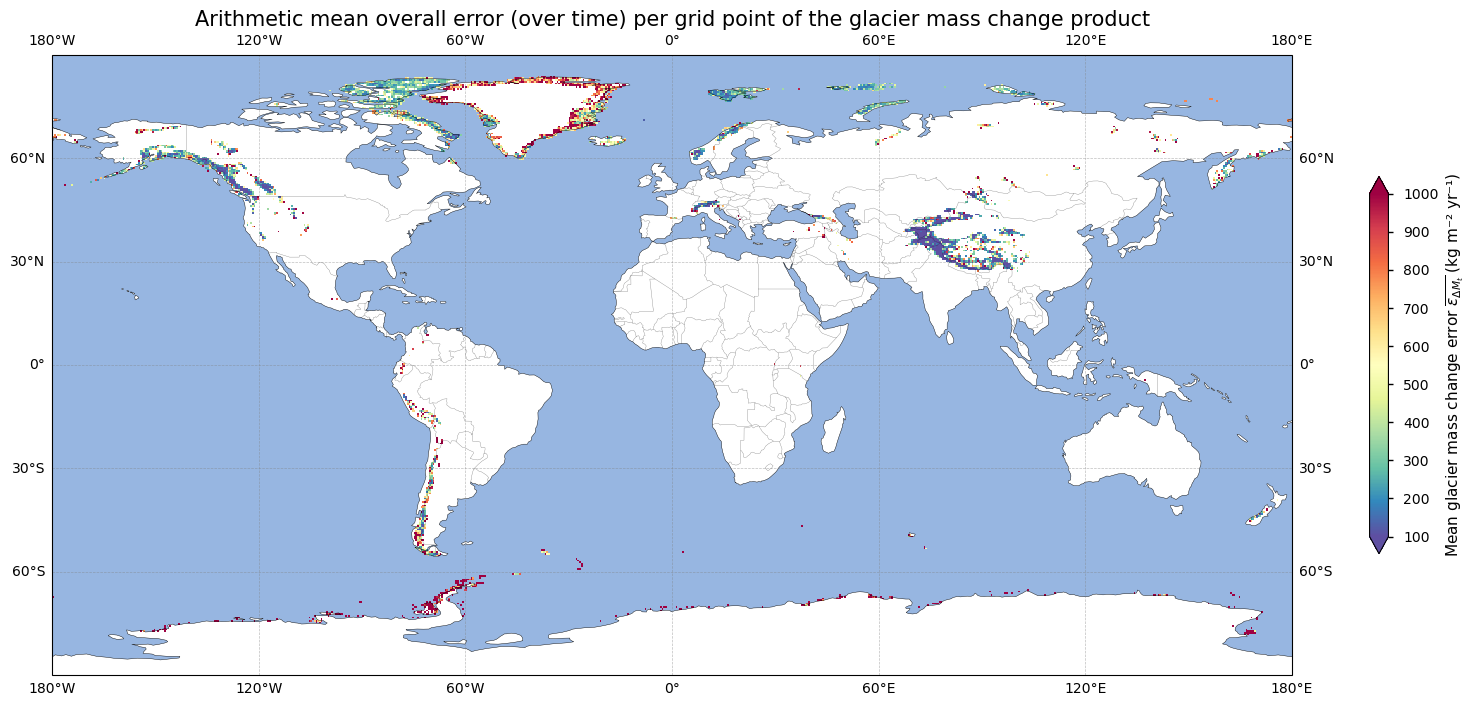

In [11]:
# Plot the gridded data
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
error_spatial = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2']).mean(("time"), keep_attrs=True)
im=ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, error_spatial, transform=ccrs.PlateCarree(), cmap = mpl.cm.Spectral_r, vmin=100,vmax=1000)
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Mean glacier mass change error $\overline{\epsilon_{\Delta{M_{t}}}}$ (kg m⁻² yr⁻¹)')
plt.title('Arithmetic mean overall error (over time) per grid point of the glacier mass change product',fontsize=15)
plt.show()

*<center>Figure 3. Spatial distribution of temporally averaged glacier mass change errors for each pixel in the glacier mass change dataset.</center>*

Let us make this plot a bit clearer by grouping these errors with respect to the threshold values proposed by GCOS [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]:

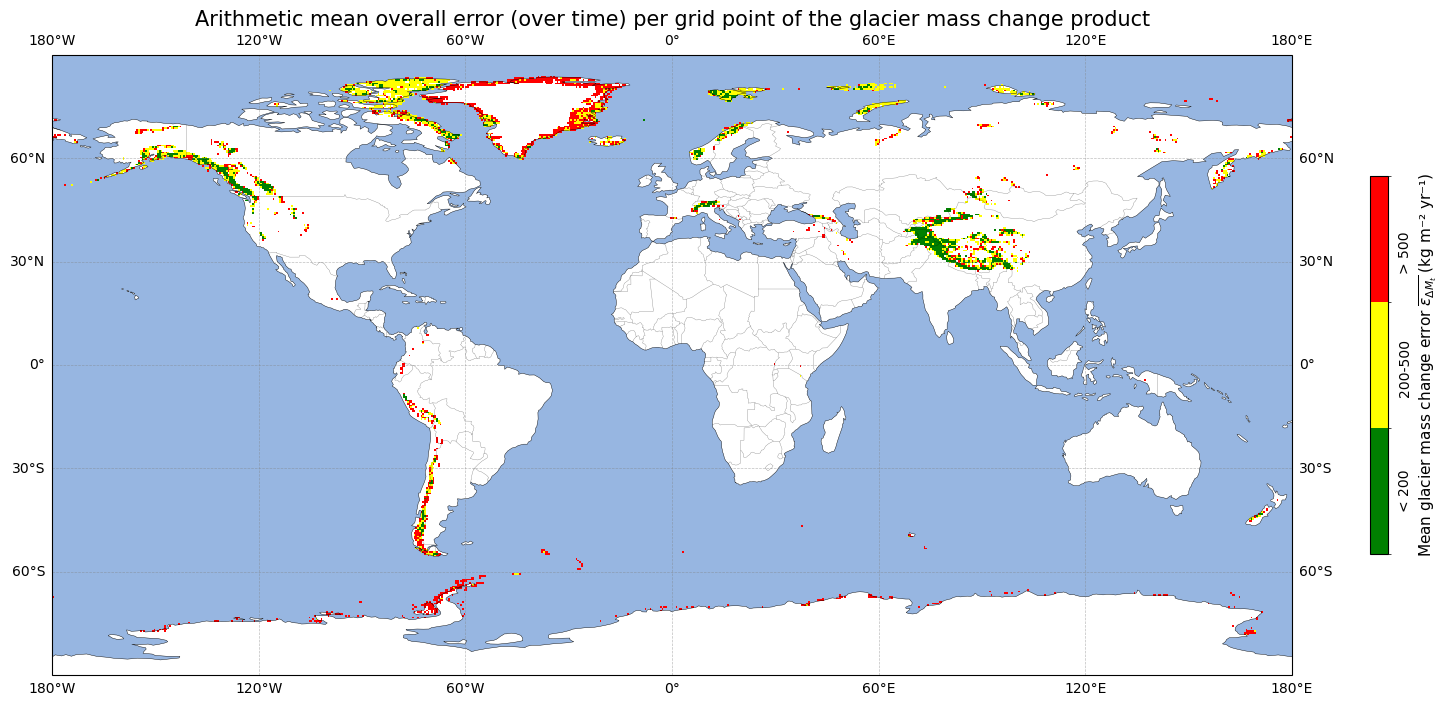

In [12]:
# Define the boundaries for the colorbar
bounds = [0, 200, 500, np.nanmax(error_spatial)]
cmap = mpl.colors.ListedColormap(['green','yellow', 'red'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
error_spatial = (1e6 * ds['uncertainty_gt'] / ds['glacier_area_km2']).mean(("time"), keep_attrs=True)
# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, error_spatial, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Mean glacier mass change error $\overline{\epsilon_{\Delta{M_{t}}}}$ (kg m⁻² yr⁻¹)', spacing="uniform")
cb.set_ticks([(0+250)/2, (200+600)/2, (650+np.nanmax(error_spatial))/2])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels(['< 200', '200-500', '> 500'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Arithmetic mean overall error (over time) per grid point of the glacier mass change product', fontsize=15)
plt.show()

*<center>Figure 4. Spatial distribution of temporally averaged glacier mass change errors for each pixel in the glacier mass change dataset, classified by proposed GCOS thresholds [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)].</center>*

Green pixels indicate areas where the breakthrough value of (an uncertainty of 200 kg m⁻² yr⁻¹ or lower), as proposed by GCOS, has been reached, whereas red grid points exhibit temporally arithmetic mean error values that exceed the threshold value (500 kg m⁻² yr⁻¹ or more) for the data to be useful. This confirms our statement from above: especially the Greenland and Antarctic peripheral glaciers and parts of the Andes exhibit error values that are clearly too high. Extra care from the user is required in these regions since the threshold value has not been reached. Other regions, such as High Mountain Asia and the majority of Alaskan and European glaciers, have precision error values that allow for a reliable and high-quality data analysis. Possible reasons for this pattern are sparse data coverage, complex terrain, and gridded data limitations.

Let us quantify the percentage of data (over all pixels and all years) that do and do not reach the threshold values:

In [13]:
# Quantify the percentage of data that do and do not reach the threshold values
error_spatial = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2'])
count_200 = (error_spatial < 200).sum().values
count_500 = (error_spatial > 500).sum().values
count_nonnan = np.sum(~np.isnan(error_spatial).values)
print(f"The percentage of data points with a glacier mass change error value less than 200 kg m⁻² yr⁻¹ is {(100*count_200/count_nonnan):.2f}%.")
print(f"The percentage of data points with a glacier mass change error value more than 500 kg m⁻² yr⁻¹ is {(100*count_500/count_nonnan):.2f}%.")

The percentage of data points with a glacier mass change error value less than 200 kg m⁻² yr⁻¹ is 21.79%.
The percentage of data points with a glacier mass change error value more than 500 kg m⁻² yr⁻¹ is 38.36%.


Now, let us plot the global annual mass change data over time and propagate its error throughout the time series.

### Quantifying global (cumulative) glacier mass changes since 1975-1976

In the following section, we plot the global annual (and cumulative) glacier mass change over time. For the annual values, we therefore sum the gridded mass change product over the entire spatial domain for each individual year to get spatially summed values in Gt yr⁻¹, and calculate the glacier area-weighted mean to get a mass balance value in m w.e. yr⁻¹:

$\Delta M_i 
$
[Gt yr⁻¹]
$ = \sum\limits^{x,y}\Delta {M_{x,y}}$ 

where $\Delta {M_{x,y}}$ is the glacier mass change (from `glacier_mass_change_gt`, in Gt yr⁻¹) at pixel $x,y$ during a certain year $i$, and

${\Delta B_i} 
$
[m w.e. yr⁻¹]
$ = \textstyle\dfrac{1}{\sum\limits^{x,y} A_{x,y}} {\sum\limits^{x,y} (A_{x,y} * \Delta {B_{x,y}})}$ 

where $\Delta {B_{x,y}}$ is the glacier mass balance (from `glacier_mass_change_mwe`, in m w.e. yr⁻¹) and $A_{x,y}$ the glacier area [km$^2$] at pixel $x,y$ (from `glacier_area_km2`) during a certain year $i$.

This results in the following plot: 

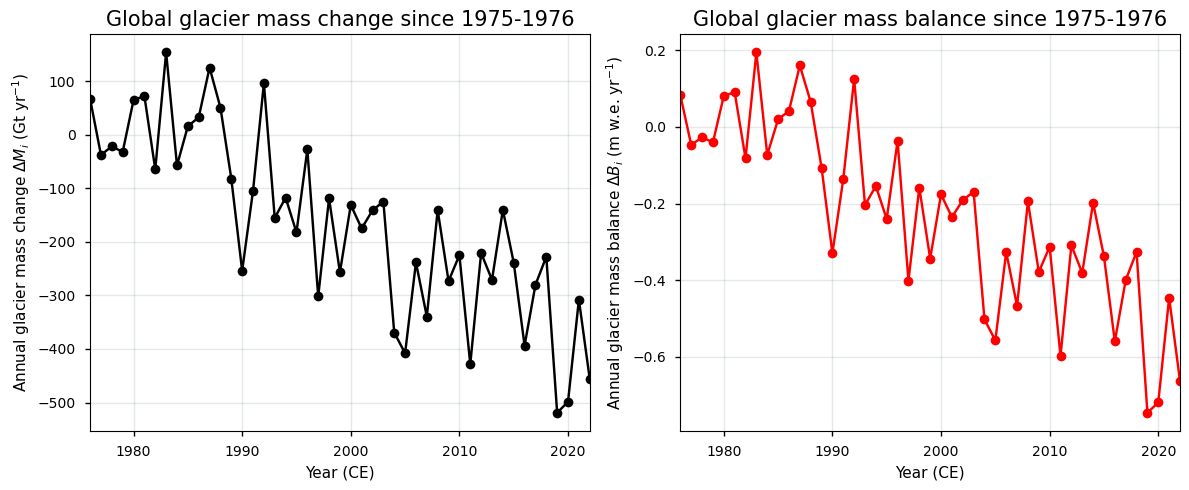

In [14]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(ds["time"],ds["Annual_gt"].values,color='k',marker='o')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel(r"Annual glacier mass change $\Delta M_i$ (Gt yr$^{-1}$)")
ax1.set_title("Global glacier mass change since "+ period_start.replace("_","-"),fontsize=15);
ax2.plot(ds["time"],ds["Annual_mwe"].values,color='r',marker='o')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel("Annual glacier mass balance $\Delta B_i$ (m w.e. yr$^{-1}$)")
ax2.set_title("Global glacier mass balance since "+ period_start.replace("_","-"),fontsize=15);
plt.tight_layout()
plt.show()

*<center>Figure 5. Annual global (left) glacier mass changes (expressed in Gt yr⁻¹) and (right) mass balances (expressed in m w.e. yr⁻¹) from the glacier mass change dataset.</center>*

The mass changes in the left plot above are expressed in Gt yr$^{-1}$ (Gigatonnes per year). Since Gt is a unit of mass, the mass of 1 Gt of ice is exactly the same as the mass of 1 Gt of water. The value can, however, also be translated into a volume. For example, 1 Gt of water (density 1000 kg/m³) is exactly 1 km³ water, while 1 Gt of ice (density 917 kg/m³) becomes 1.091 km³ of ice in volume. The corresponding annual global mass change uncertainty is calculated by assuming that errors are spatially uncorrelated and hence independent. For error propagation, we divide the uncertainty estimates by 1.96 since errors values are reported as 1.96 times the standard deviation:

$
\sigma_{\Delta{M_i}} 
$
[Gt yr⁻¹]
$= \sqrt{\sum\limits^{x,y}({\sigma_{ \Delta{M_{x,y}}}})^2}
$

where $\sigma_{ \Delta{M_{x,y}}}$ is the mass change standard deviation (from `uncertainty_gt` divided by 1.96, in Gt yr⁻¹) at pixel $x,y$ during a certain year, and

$
\sigma_{{\Delta{B_i}}} 
$
[m w.e. yr⁻¹]
$= \sqrt{\sum\limits^{x,y} \left( \dfrac{A_{x,y}}{\sum\limits^{x,y} A_{x,y}} * {\sigma_{{\Delta{B}_{x,y}}}} \right)^2 }
$

where $\sigma_{{ \Delta{B_{x,y}}}}$ is the mass balance standard deviation (from `uncertainty_mwe` divided by 1.96, in m w.e. yr⁻¹) at pixel $x,y$ during a certain year and $A_{x,y}$ the glacier area [km$^2$] (from `glacier_area_km2`).

Plotting these data reveals the following:

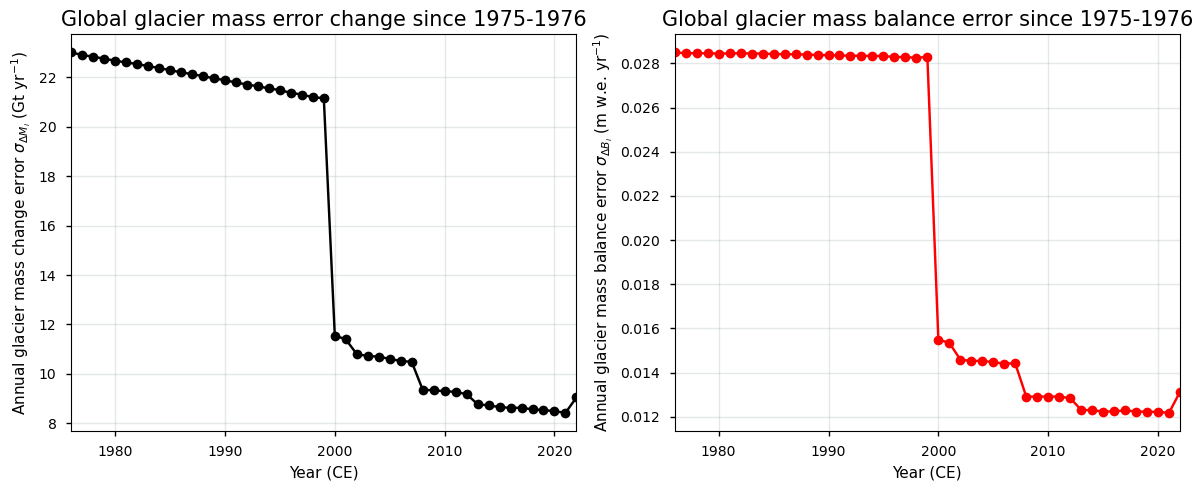

In [15]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(ds["time"],ds["Annual_error_gt"].values,color='k',marker='o')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel(r"Annual glacier mass change error $\sigma_{\Delta M_i}$ (Gt yr$^{-1}$)")
ax1.set_title("Global glacier mass error change since "+ period_start.replace("_","-"),fontsize=15);
ax2.plot(ds["time"],ds["Annual_error_mwe"].values,color='r',marker='o')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel(r"Annual glacier mass balance error $\sigma_{{\Delta B_i}}$ (m w.e. yr$^{-1}$)")
ax2.set_title("Global glacier mass balance error since "+ period_start.replace("_","-"),fontsize=15);
plt.tight_layout()
plt.show()

*<center>Figure 6. Annual global glacier mass change errors from the glacier mass change dataset expressed in units of (left) Gt yr⁻¹ (mass changes) and (right) m w.e. yr⁻¹ (mass balances).</center>*

It can be seen from the plot that the global glacier mass change uncertainty has been decreasing over time, with a sudden drop around 2000 CE. Note that due to potential spatial autocorrelation, the error in the above estimate (assuming independent errors) might be underestimated.

The data can also be plotted in a cumulative way:

$
{M} 
$
[Gt]
$
= \sum\limits_{i={1976}}^{{{1976+n-1}}} (\Delta M_i)
$
, or

$
{{B}} 
$
[m w.e.]
$
= \sum\limits_{i={1976}}^{{{1976+n-1}}} ({\Delta B_i})
$

with the global annual glacier mass change (in Gt yr⁻¹) or balance (m w.e. yr⁻¹) at a certain year $i$ (as calculated above) and $n$ the number of years in the time series.

The corresponding uncertainty is again calculated by assuming uncorrelated errors:

$
\sigma_{{M}}
$
[Gt]
$
= \sqrt{\sum\limits_{i={1976}}^{{1976+n-1}} (\sigma_{\Delta{M_i}})^2}
$
, or

$
\sigma_{{{B}}}
$
[m w.e.] = 
$
\sqrt{\sum\limits_{i={1976}}^{{1976+n-1}} (\sigma_{{\Delta{B_i}}})^2}
$

with the global annual mass change (in Gt yr⁻¹) or balance (m w.e. yr⁻¹) uncertainty at a certain year $i$ (as calculated above) and $n$ the number of years in the time series.

The corresponding plot looks as follows (note that in the cumulative time series, we multiply the propagated errors again by 1.96 to be consistent with the original errors presented in the dataset):

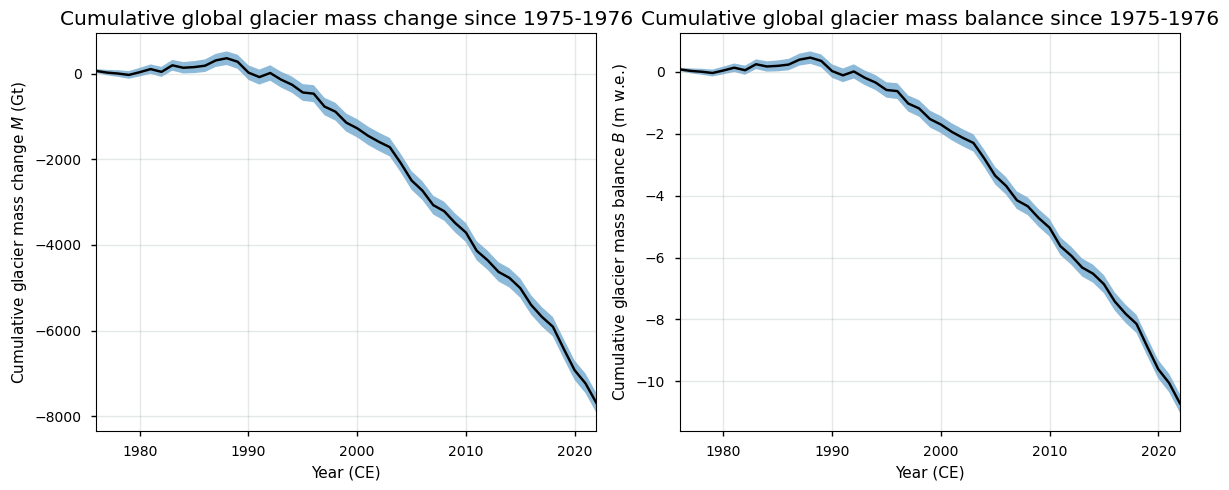

In [16]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
line1 = ds["Cumulative_gt"]
error1 = ds["Cumulative_error_gt"]
ax1.fill_between(line1["time"], line1 - error1*1.96, line1 + error1*1.96, alpha=0.5)
line1.plot(ax=ax1, color="k")
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel("Cumulative glacier mass change $M$ (Gt)")
ax1.set_title("Cumulative global glacier mass change since "+ period_start.replace("_","-"),fontsize=14.5);
line2 = ds["Cumulative_mwe"]
error2 = ds["Cumulative_error_mwe"]
ax2.fill_between(line2["time"], line2 - error2*1.96, line2 + error2*1.96, alpha=0.5)
line2.plot(ax=ax2, color="k")
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel("Cumulative glacier mass balance ${B}$ (m w.e.)")
ax2.set_title("Cumulative global glacier mass balance since "+ period_start.replace("_","-"),fontsize=14.5);
plt.tight_layout()
plt.show()

*<center>Figure 7. Annual global cumulative (left) glacier mass changes (expressed in Gt yr⁻¹) and (right) mass balances (expressed in m w.e. yr⁻¹), with error propagation (assuming independent errors, shaded).</center>*

From the image above, it can be seen that glaciers clearly have been losing mass during the observational period, especially since the 1990s. The final estimate of the glaciers mass change at the end of the time series is:

In [17]:
print(f"The total global cumulative glacier mass change between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {line2.values[-1]:.2f} ± {error2.values[-1]*1.96:.2f} m w.e. or {line1.values[-1]:.2f} ± {error1.values[-1]*1.96:.2f} Gt.")

The total global cumulative glacier mass change between 1975-1976 and 2021-2022 is -10.72 ± 0.30 m w.e. or -7691.70 ± 230.53 Gt.


Note that due to potential spatial/temporal error correlation in the time series, the error in the above estimate (assuming independent errors) might be underestimated. Now, let us use the glacier mass change data to quantify the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring.

### Quantification of glacier-related contributions to global sea level change

We can calculate the cumulative contribution of glacier mass changes to global sea level change during the last several decades by making use of the following formula [[5](https://www.nature.com/articles/s41561-019-0300-3)]:

$
h_{SLE} 
$
[mm]
$
= 1 \cdot 10^6 * \sum\limits_{i=1976}^{1976+n-1} \left(\dfrac{V_{w,i}}{A_s} * \dfrac{\rho_w}{\rho_s}\right)
$

where 
$
{V_{w,i}} = \sum\limits^{x,y}\left(\dfrac{\Delta {B_{x,y}}}{1 \cdot 10^3} * A_{x,y}\right)
$.

Here, $\Delta {B_{x,y}}$ is the glacier mass balance (in m w.e. yr⁻¹) at pixel $x,y$ during a certain year $i$ from `ds["glacier_mass_change_mwe"]`, and $A_{x,y}$ the glacier area [km$^2$] from `ds["glacier_area_km2"]`, so that the annual volume change $V_w$ has units of km$^3$ yr$^{-1}$ of water. Furthermore, ${A_{s}}$ is the ocean surface area [km²], $n$ the total number of years in the time series and $\rho$ the respective densities of water $w$ and the sea $s$ [kg m⁻³]. Note that this formulation assumes that all glacier mass or volume losses directly contribute to sea level changes, while this is not necessarily the case (e.g. [[6](https://iopscience.iop.org/article/10.1088/1748-9326/aac2f0/meta), [7](https://tc.copernicus.org/articles/14/833/2020/)]). Also note that by multiplying the sea level contribution by $\frac{\rho_w}{\rho_s}$, we calculate sea level contributions in ocean water column equivalent.

The corresponding uncertainty is given by:

$
\sigma_{h_{SLE}} 
$
[mm] = 
$
1 \cdot 10^6 * \left(\dfrac{1}{A_s} \dfrac{{\rho_{w}}}{\rho_{s}}\right) * \sqrt{ \sum\limits_{i={1976}}^{{{1976+n-1}}} (\sigma_{{V_{w,i}}})^2}
$

where $\sigma_{\Delta{V_w}}$ is the corresponding volume change uncertainty [km$^{3}$ yr$^{-1}$] calculated from the mass balance uncertainty and the glacier area, again taking into account that uncertainties at the pixel level are given as 1.96 times the standard deviation.

This results in:

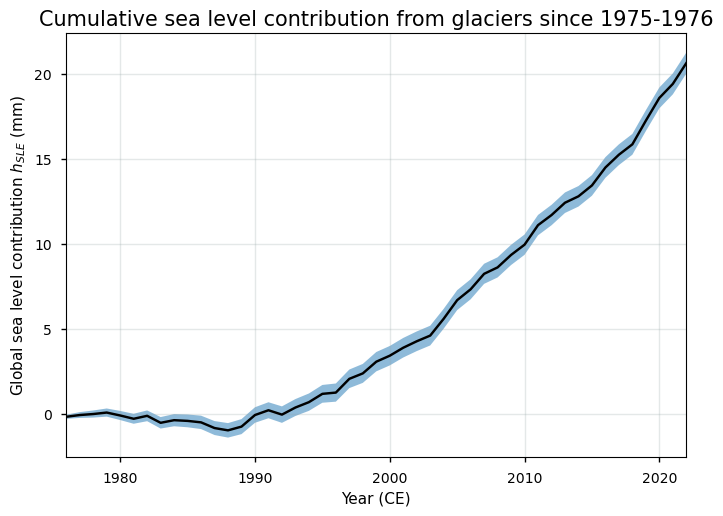

In [18]:
# Define some variables
A_ocean = 3.625E8  # Ocean surface area
p_ice = 917        # Ice density
p_sea = 1028       # Ocean water density
p_water = 1000     # Fresh water density
# Calculate global sea level contribution
vol_ice = (((ds["glacier_mass_change_mwe"]/1000) * ds["glacier_area_km2"]).sum(dim=("latitude", "longitude"), keep_attrs=True)).cumsum("time")
hsle = -1E6*(vol_ice/(A_ocean))*(p_water/p_sea)             
vol_ice_error = (((ds["glacier_area_km2"] * ((ds['uncertainty_mwe']/1000)/1.96)) ** 2).sum(dim=['latitude', 'longitude'],keep_attrs=True) ** 0.5)
cumulative_vol_ice_error = ((vol_ice_error**2).cumsum("time")) ** 0.5
hsle_error = 1E6*(((p_water/p_sea)/(A_ocean))**2*(cumulative_vol_ice_error)**2) ** 0.5
# Plot the data
fig, ax = plt.subplots()
line = hsle
error = hsle_error
ax.fill_between(line["time"], line - error*1.96, line + error*1.96, alpha=0.5)
line.plot(ax=ax, color="k")
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax.set_xlabel("Year (CE)")
ax.set_ylabel("Global sea level contribution $h_{SLE}$ (mm)")
ax.set_title("Cumulative sea level contribution from glaciers since "+ period_start.replace("_","-"),fontsize=15);
plt.show()

*Figure 8. Cumulative contribution of glacier mass changes to global sea level changes (assuming all glacier mass changes contribute to sea level changes), including the propagation of the error (shaded).*

Let us quantify the total glacier-related contribution to global sea level change since the beginning of the dataset:

In [19]:
print(f"The total contribution of glacier mass changes to global sea level change between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {line.values[-1]:.2f} ± {error.values[-1]*1.96:.2f} mm.")

The total contribution of glacier mass changes to global sea level change between 1975-1976 and 2021-2022 is 20.64 ± 0.62 mm.


The glacier mass change dataset on the CDS is thus considered highly suitable for monitoring and deriving global cumulative mass changes over time, as well as assessing their impact on global sea level changes. Expressed in Gt yr⁻¹ or m w.e. yr⁻¹, the data can be directly linked to sea level contributions, provided that all mass changes are assumed to affect sea levels directly (which is, however, not always the case). Calculating effective global sea level changes requires additional external data to account for factors like grounded ice below buoyancy, land-locked glaciers and floating ice. The dataset furthermore meets GCOS requirements in terms of uncertainty, spatial coverage and temporal continuity (since 1975-76 without gaps), which demostrates its maturity and reliability for Earth system modeling and climate change monitoring. However, users should exercise caution in certain areas, such as the peripheral glaciers of Antarctica and Greenland, where uncertainties are higher. Additionally, users should note limitations, such as the absence of detailed sampling density information, the fact that data can not be consulted at the individual glacier-scale, and that data are measured and generated by different institutes/research groups and from different methods. This may affect glacier mass change representativeness in some areas.

## ℹ️ If you want to know more

### Key resources

- [Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database](https://cds.climate.copernicus.eu/datasets/derived-gridded-glacier-mass-change?tab=overview)
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/derived-gridded-glacier-mass-change?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355349383) (Copernicus Knowledge Base)
- [World Glacier Monitoring Service (WGMS)](https://wgms.ch/)
- [Copernicus climate change indicators: glaciers](https://climate.copernicus.eu/climate-indicators/glaciers)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [BOpen](https://www.bopen.eu)

### References

- [[1](https://wgms.ch/)] WGMS (2022). Fluctuations of Glaciers Database. doi: 10.5904/wgms-fog-2022-09.

- [[2](https://essd.copernicus.org/preprints/essd-2024-323/)] Dussaillant, I., Hugonnet, R., Huss, M., Berthier, E., Bannwart, J., Paul, F., and Zemp, M. (2025). Annual mass changes for each glacier in the world from 1976 to 2023, Earth Syst. Sci. Data, https://doi.org/10.5194/essd-2024-323.

- [[3](https://www.nature.com/articles/s41586-019-1071-0)] Zemp, M., Huss, M., Thibert, E., Eckert, N., McNabb, R., Huber, J., Barandun, M., Machguth, H., Nussbaumer, S. U., Gärtner-Roer, I., Thomson, L., Paul, F., Maussion, F., Kutuzov, S., and Cogley, J. G. (2019). Global glacier mass changes and their contributions to sea-level rise from 1961 to 2016. Nature, 568, 382–386. doi: 10.1038/s41586-019-1071-0.

- [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)] GCOS (Global Climate Observing System) (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. doi: https://library.wmo.int/idurl/4/58111.

- [[5](https://www.nature.com/articles/s41561-019-0300-3) Farinotti, D., Huss, M., Fürst, J. J., Landmann, J., Machguth, H., Maussion, F., and Pandit, A. (2019). A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nature Geoscience, 12(3), 168-173. doi: 10.1038/s41561-019-0300-3.

- [[6](https://iopscience.iop.org/article/10.1088/1748-9326/aac2f0/meta)] Bamber, J. L., Westaway, R. M., Marzeion, B., and Wouters, B. (2018): The land ice contribution to sea level during the satellite era. Environmental Research Letters, 13(6), 063008, doi: 10.1088/1748-9326/aac2f0.

- [[7](https://tc.copernicus.org/articles/14/833/2020/)] Goelzer, H., Coulon, V., Pattyn, F., de Boer, B., and van de Wal, R. (2020). Brief communication: On calculating the sea-level contribution in marine ice-sheet models, The Cryosphere, 14, 833–840, doi: 10.5194/tc-14-833-2020.
